# Analisis univariante de una serie temporal : Paro en Estados Unidos
    

En este notebook procederemos a realizar el análisis univariante de una serie estocástica , en concreto de la tasa de paro de Estados Unidos en el sector primario. Los datos han sido sacados del FED disponibles en esta página: https://fred.stlouisfed.org/

Porsupuesto el paro es una magnitud macroeconomica muy compleja y valor actual depende de muchas cosas más aparte de sus valores pasados, el objetivo de este notebok no es otro que el de mostrar las herramientas del analisis univariante de series temporales que Python ofrece.

***

#### Creamos el entorno de trabajo.

In [1]:
# Librerias de trabajo 

#Manejo de datos
import pandas as pd
from pandas import DatetimeIndex

#Cientifico
from scipy import stats
import math

#Estadisticas 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.diagnostic as tsa

#Grafico
import matplotlib.pyplot as plt
from statsmodels.graphics.api import qqplot
%matplotlib inline

In [2]:
df = pd.read_excel("fredgraph.xls",skiprows=(14))
columnas = ["fecha","Primario","Transportes","Servicios","Oficina","alto_cargo"]
df.columns = columnas
df.index = DatetimeIndex(df["fecha"])


In [3]:
#comprobamos si hay valores nulos
pd.isnull(df).any()

fecha          False
Primario       False
Transportes    False
Servicios      False
Oficina        False
alto_cargo     False
dtype: bool

In [33]:
df["mean_paro"] = df.mean(axis=1)
df.tail()

,fecha,Primario,Transportes,Servicios,Oficina,alto_cargo,mean_paro,ln_Primario,ln_Transportes,ln_Servicios,ln_Oficina,ln_alto_cargo,ln_mean_paro,arma_res,arma_res2
fecha,,,,,,,,,,,,,,,
2018-05-01,2018-05-01,4.6,4.6,4.3,3.8,1.7,1.654669,-0.220935,0.131463,0.144065,0.208218,0.048202,0.044506,0.004926,0.004926
2018-06-01,2018-06-01,4.8,4.4,5.0,3.8,2.5,1.837127,0.341053,-0.088904,0.173812,-0.054067,0.442821,0.147082,0.078987,0.078987
2018-07-01,2018-07-01,3.8,4.4,5.1,4.0,2.4,1.611292,-0.276174,0.044452,-0.131020,0.051293,-0.426484,-0.115792,-0.114095,-0.114095
2018-08-01,2018-08-01,3.8,4.5,4.6,3.8,2.5,1.667132,0.233615,0.022473,-0.122987,-0.102587,0.081644,0.014098,0.086795,0.086795
2018-09-01,2018-09-01,3.8,4.3,4.3,3.6,2.0,1.508178,0.000000,-0.067935,0.035743,-0.002774,-0.263966,-0.038830,-0.073873,-0.073873


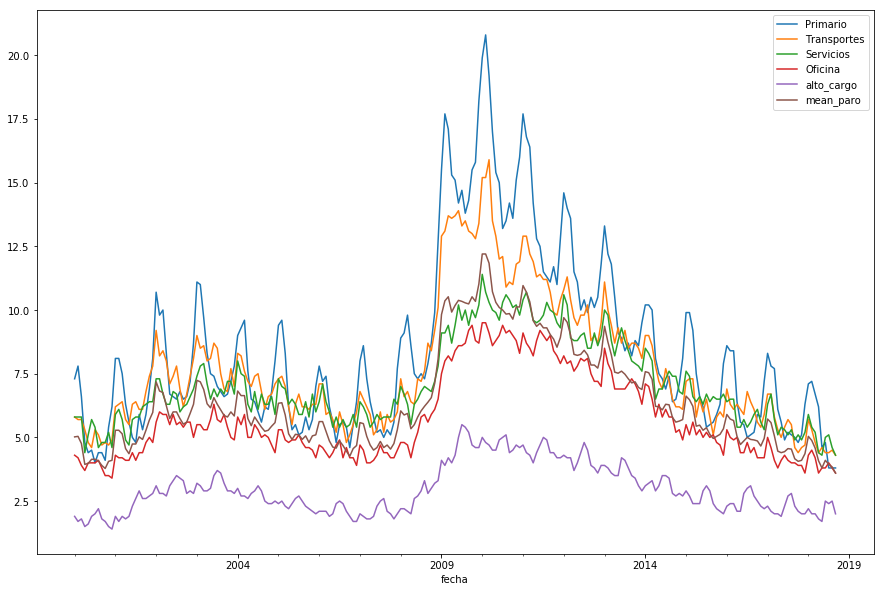

In [5]:
df1 = df[df.columns[1:7]]
df1.plot(legend= True,figsize=(15,10))

***
Ya a simple vista podemos observar que el la tasa de paro en el sector ``Primario`` es mucho mas acusada que en el resto de los sectores, soportando subidas y bajadas mucho mas acusadas que en el resto de los sectores. 

In [6]:
# Aplicamos transformacion de Box- Cox
df["ln_Primario"] = df.Primario.apply(math.log)
df["ln_Transportes"]= df.Transportes.apply(math.log)
df["ln_Servicios"] = df.Servicios.apply(math.log)
df["ln_Oficina"]= df.Oficina.apply(math.log)
df["ln_alto_cargo"]= df.alto_cargo.apply(math.log)
df["ln_mean_paro"]= df.mean_paro.apply(math.log)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FF09D6FEB8>,
      dtype=object)

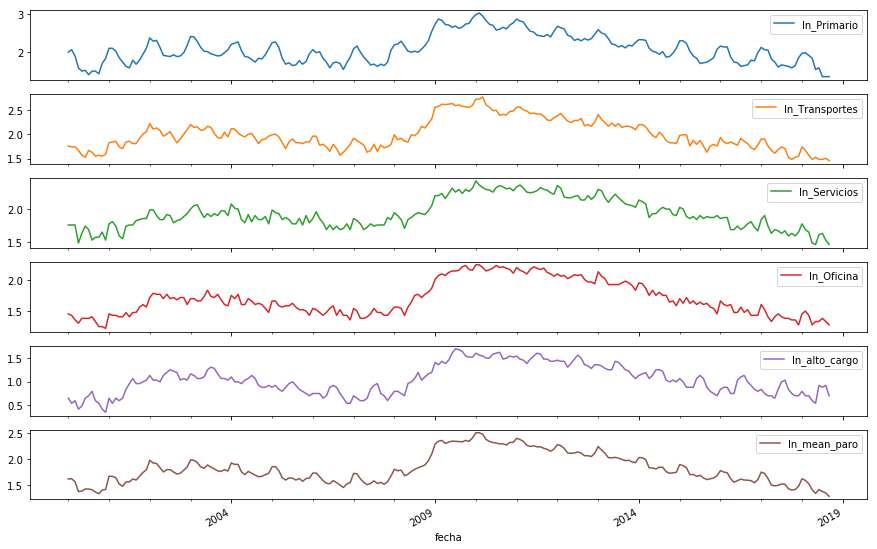

In [7]:
dfln = df[df.columns[7:]]
dfln.plot(legend= True,figsize=(15,10),subplots=True)


In [9]:
# Aplicamos proceso diferencia
df[df.columns[7:]] = df[df.columns[7:]].diff()
df = df.dropna()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FF09D61710>,
      dtype=object)

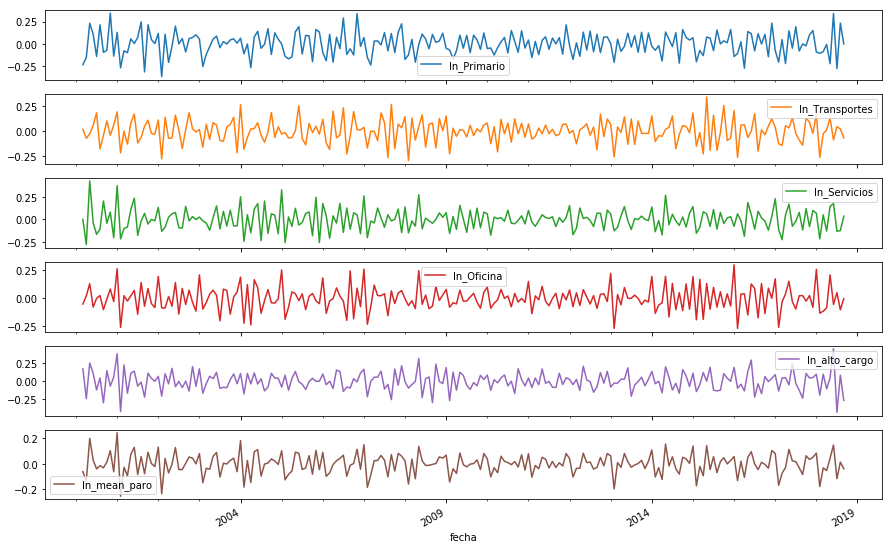

In [10]:
dfest = df[df.columns[7:]]
dfest.plot(legend= True,figsize=(15,10),subplots=True)

Esto lo podriamos interpretar como la tasa de crecimeinto de la tasa de paro segun los distintos sectores.
Podemos apreciar que se mueven de forma bastante parecidas

C:\Users\tito-\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


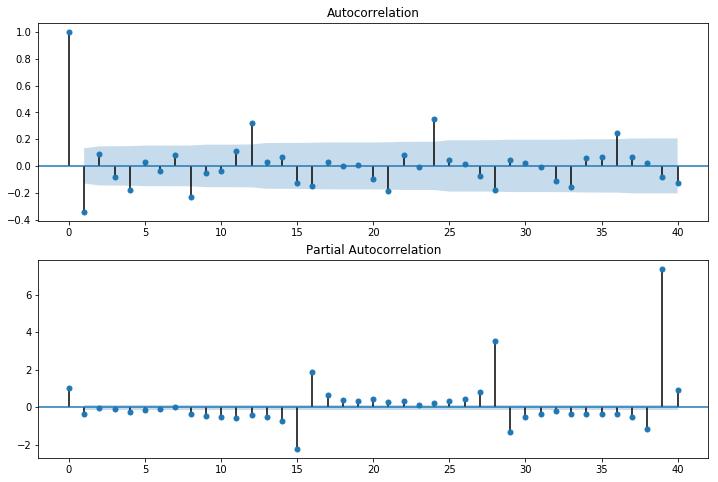

In [17]:
#corelogramas de el ln de Primario, diferenciado 1 periodo
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.ln_Primario, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.ln_Primario, lags=40, ax=ax2)

In [16]:
modelo= sm.tsa.ARMA(df.ln_Primario, order=(2,0) )
arma_res = modelo.fit(disp=True)
print(arma_res.summary())

                              ARMA Model Results                              
Dep. Variable:            ln_Primario   No. Observations:                  223
Model:                     ARMA(2, 0)   Log Likelihood                 152.300
Method:                       css-mle   S.D. of innovations              0.122
Date:                Sun, 14 Oct 2018   AIC                           -296.601
Time:                        16:15:35   BIC                           -282.972
Sample:                    03-01-2000   HQIC                          -291.099
                         - 09-01-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.211e-05      0.006     -0.002      0.998      -0.012       0.012
ar.L1.ln_Primario    -0.3567      0.068     -5.271      0.000      -0.489      -0.224
ar.L2.ln_Primario    -0.

C:\Users\tito-\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


#### Este modelo es estacionario por muy poco, asi que podriamos concluir que no es estacionario.

Pero veamos como se comporta.

In [19]:
df["arma_res"]= arma_res.fittedvalues 
dffit = df[["ln_Primario","arma_res"]]

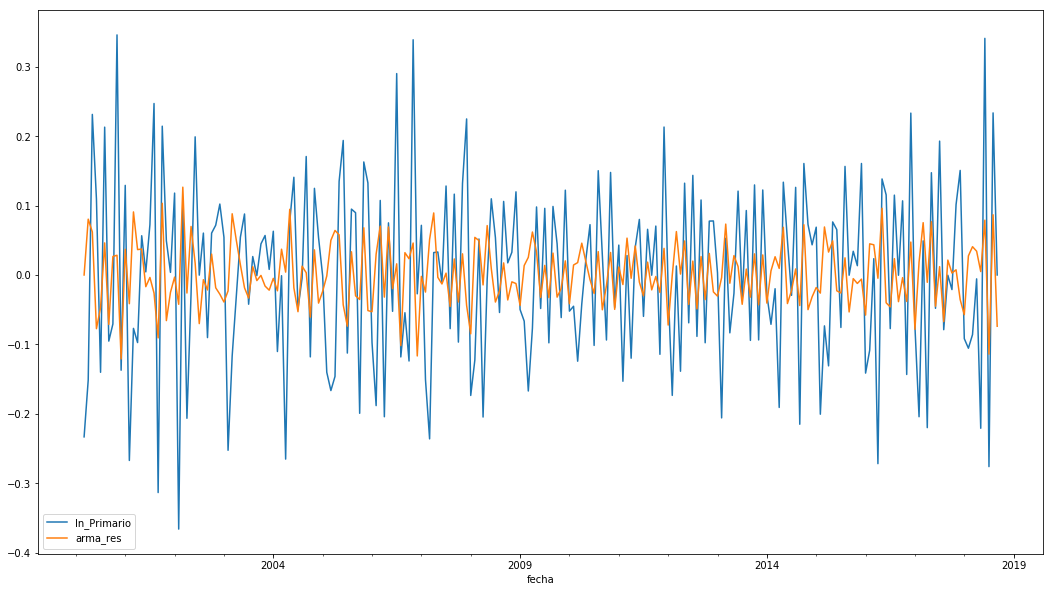

In [20]:
dffit.plot(figsize=(18,10))

In [21]:
resid = arma_res.resid

In [22]:
stats.normaltest(resid)

NormaltestResult(statistic=1.6147112872608569, pvalue=0.44603598621763796)

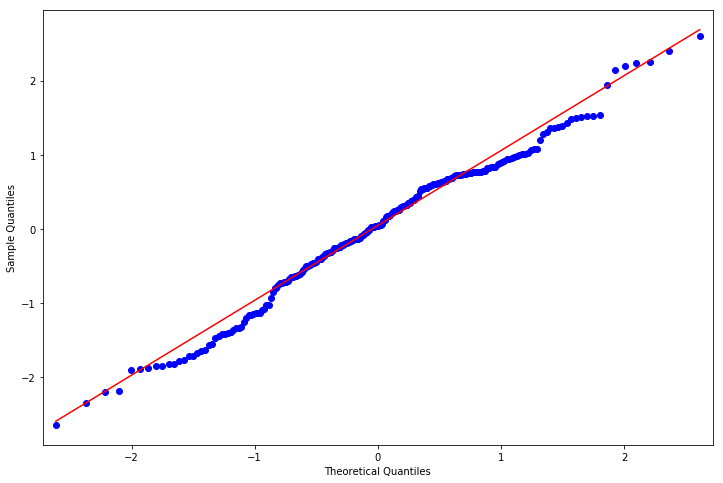

In [23]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

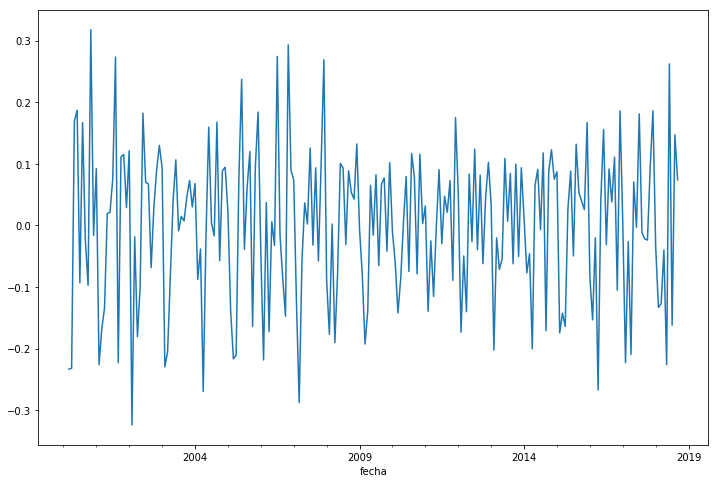

In [24]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_res.resid.plot(ax=ax)

In [25]:
sm.stats.durbin_watson(arma_res.resid.values)

1.9746793756241152

Podemos decir que los errores no tienen correlación, veamos ahora con el test de Jung - Box si se comportan como un ruido blanco.

In [26]:
tsa.acorr_ljungbox(arma_res.resid.values, lags=None, boxpierce=True)

(array([3.08317688e-03, 1.92687063e-01, 5.91731301e+00, 2.07146015e+01,
        2.14140468e+01, 2.14737228e+01, 2.14816986e+01, 4.09861747e+01,
        4.77655430e+01, 4.78433864e+01, 6.39584810e+01, 1.16334660e+02,
        1.25785720e+02, 1.26285206e+02, 1.36114738e+02, 1.49421183e+02,
        1.49745937e+02, 1.49746120e+02, 1.50115356e+02, 1.59738076e+02,
        1.74126608e+02, 1.74505832e+02, 1.81732592e+02, 2.36161437e+02,
        2.47022934e+02, 2.47057669e+02, 2.53715647e+02, 2.69004057e+02,
        2.69043998e+02, 2.69271127e+02, 2.69944037e+02, 2.81166705e+02,
        2.94030401e+02, 2.94407856e+02, 3.05691067e+02, 3.42739396e+02,
        3.52739952e+02, 3.52914762e+02, 3.58746385e+02, 3.70133715e+02]),
 array([9.55719128e-01, 9.08151984e-01, 1.15703164e-01, 3.60708653e-04,
        6.76377808e-04, 1.50749398e-03, 3.11893820e-03, 2.09704903e-06,
        2.82506634e-07, 6.62898762e-07, 1.69089869e-09, 3.31711419e-19,
        1.43916637e-20, 3.67039287e-20, 1.34119526e-21, 1.0160

Segun el test los residuos no se acaban de comportar como un riudo blanco.

#### Pasemos a la predicción

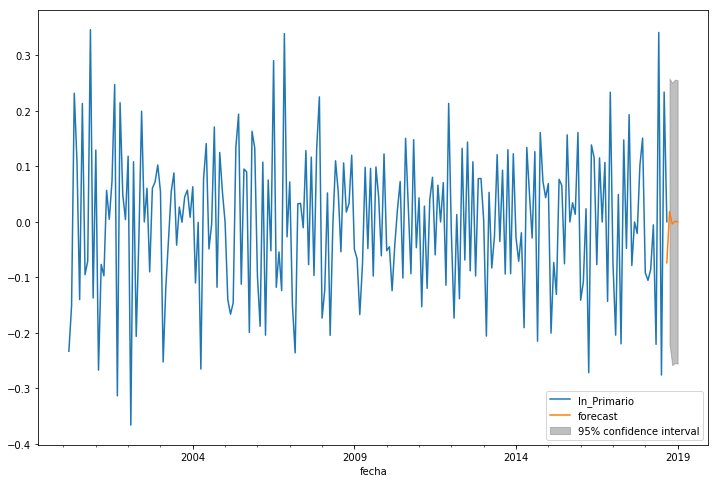

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = df.ln_Primario.plot(ax=ax)
fig = arma_res.plot_predict('2018-09-01', '2019', dynamic=True, ax=ax, plot_insample=False)

Es normal que tengamos esta predicción teneindo encuenta que estamos tratando un ARMA(2,0) o lo que vendria siendo un autorregresivo de orden 2 por lo tanto las prediciones solo serian "fiables" para dos perodos hacia adelante. 

***


### Pasemos ahora a un modelo ARIMA 

Esto seria un procero ARMA aplicado a la difresncia $\Delta{X_t}$ esto lo podriamos interpretar a la practica como un modelo que defina la tasa de variacíon de la tasa de paro del sector primario en USA.

C:\Users\tito-\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


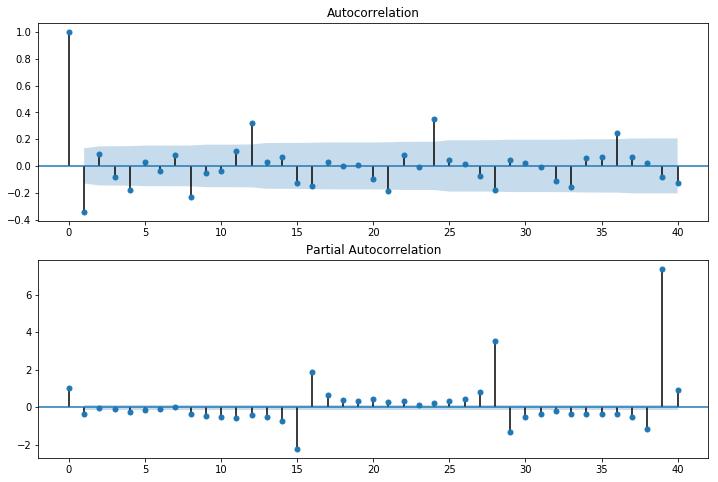

In [28]:
#corelogramas de el ln de Primario, diferenciado 1 periodo
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.ln_Primario, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.ln_Primario, lags=40, ax=ax2)

In [29]:
modelo2= sm.tsa.ARMA(df.ln_Primario, order=(2,0))
arma_res2 = modelo2.fit(disp=True)
print(arma_res2.summary())

                              ARMA Model Results                              
Dep. Variable:            ln_Primario   No. Observations:                  223
Model:                     ARMA(2, 0)   Log Likelihood                 152.300
Method:                       css-mle   S.D. of innovations              0.122
Date:                Sun, 14 Oct 2018   AIC                           -296.601
Time:                        16:17:33   BIC                           -282.972
Sample:                    03-01-2000   HQIC                          -291.099
                         - 09-01-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.211e-05      0.006     -0.002      0.998      -0.012       0.012
ar.L1.ln_Primario    -0.3567      0.068     -5.271      0.000      -0.489      -0.224
ar.L2.ln_Primario    -0.

C:\Users\tito-\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


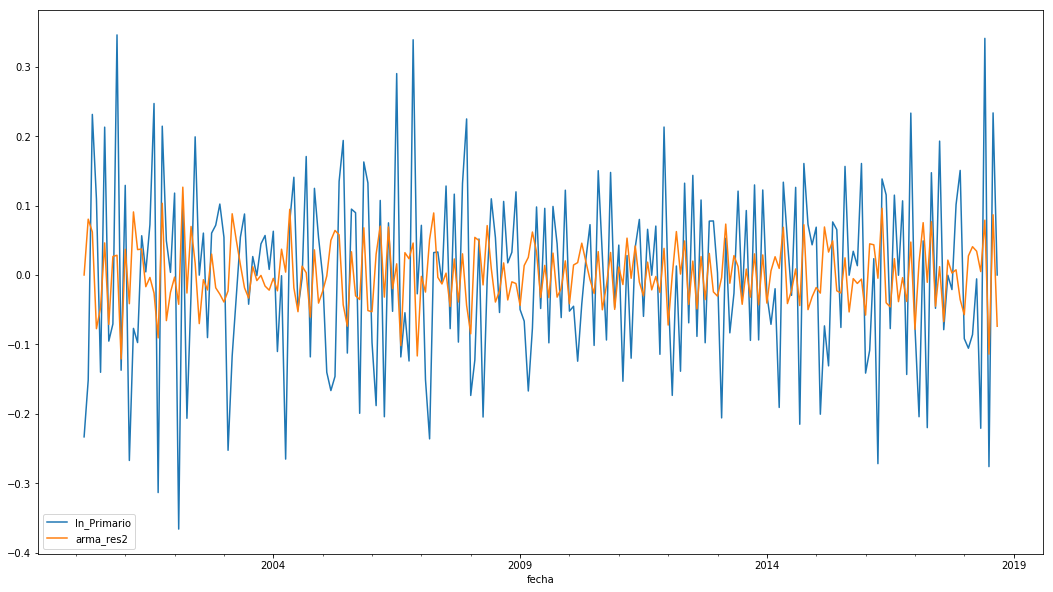

In [30]:
df["arma_res2"]= arma_res2.fittedvalues 
dffit = df[["ln_Primario","arma_res2"]]
dffit.plot(figsize=(18,10))

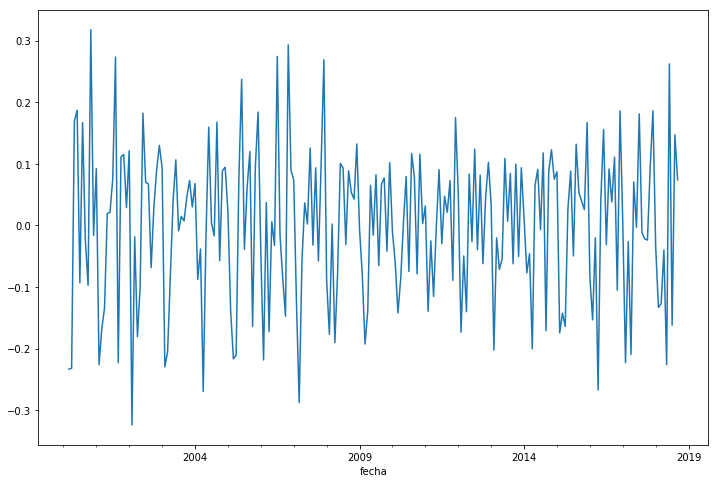

In [31]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_res2.resid.plot(ax=ax)

In [33]:
resid2 = arma_res2.resid

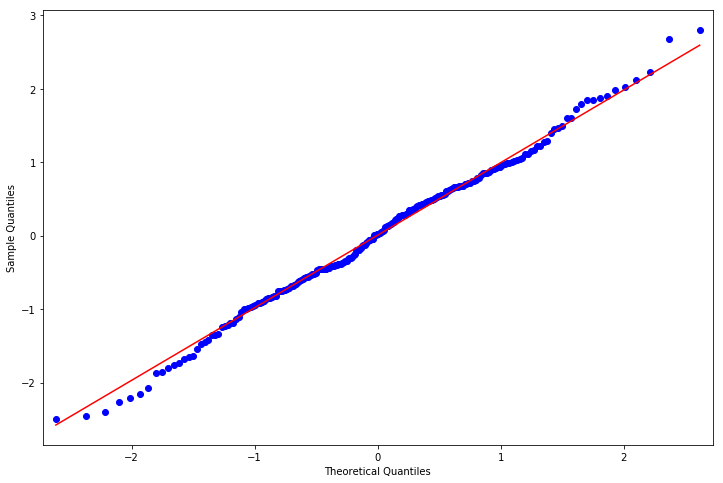

In [34]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid2, line='q', ax=ax, fit=True)

Podemos decir que los errores no tiene correlacion 

In [35]:
sm.stats.durbin_watson(arma_res2.resid.values)

1.9725151643770102

In [36]:
stats.normaltest(resid2)

NormaltestResult(statistic=0.049578702995967464, pvalue=0.9755153812404341)

In [44]:
tsa.acorr_ljungbox(arma_res2.resid.values, lags=None, boxpierce=True)

(array([3.71443750e-02, 2.48307886e+00, 4.95852670e+00, 1.89125629e+01,
        2.21398995e+01, 2.64680765e+01, 2.78863930e+01, 4.77458907e+01,
        5.01546040e+01, 5.04916880e+01, 6.94360101e+01, 1.23093622e+02,
        1.35009173e+02, 1.37865817e+02, 1.42853788e+02, 1.55015714e+02,
        1.57567073e+02, 1.60474348e+02, 1.64112351e+02, 1.73655306e+02,
        1.83306760e+02, 1.85666005e+02, 1.93588269e+02, 2.47808466e+02,
        2.60114534e+02, 2.61196948e+02, 2.64070952e+02, 2.77981756e+02,
        2.79498766e+02, 2.81264648e+02, 2.85177043e+02, 2.95962634e+02,
        3.04285117e+02, 3.06027824e+02, 3.17823313e+02, 3.55147758e+02,
        3.66725504e+02, 3.68089105e+02, 3.70899432e+02, 3.81171914e+02]),
 array([8.47171398e-01, 2.88939074e-01, 1.74859335e-01, 8.17648071e-04,
        4.92485224e-04, 1.82093615e-04, 2.30562462e-04, 1.10483904e-07,
        1.00747663e-07, 2.16703163e-07, 1.56350898e-10, 1.49124692e-20,
        2.09678252e-22, 1.88346909e-22, 6.28712741e-23, 7.9849

Segun el test se comporta como un ruido blanco 

### Pasemos ahora a la predicción

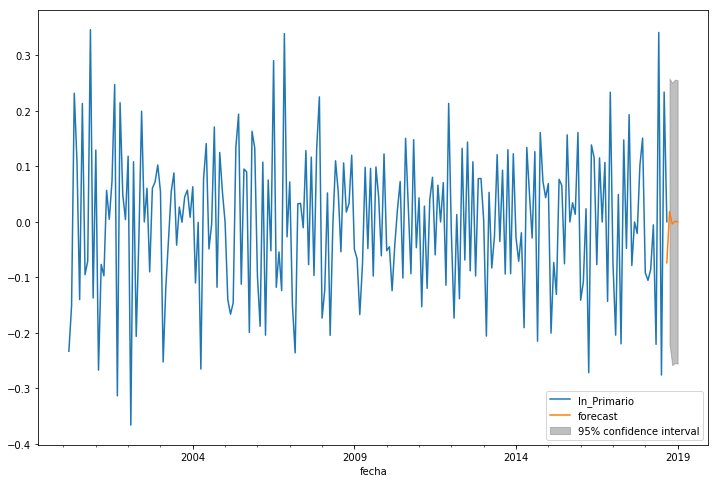

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = df.ln_Primario.plot(ax=ax)
fig = arma_res2.plot_predict('2018-09-01', '2019', dynamic=True, ax=ax, plot_insample=False)

## Filtro Hodrick y Prescott

El filtro HP es uno delos más usados en economia para el analisis del PIB, separando la tendencia del ciclo de forma que:$$y_t\ = \tau_t\ + c_t\ + \epsilon_t\,$$
El filtro HP funciona segun la minimizacion de la siguente función cuadratica:
<math>$$\min_{\tau}\left(\sum_{t = 1}^T {(y_t - \tau _t )^2 }  + \lambda \sum_{t = 2}^{T - 1} {[(\tau _{t+1}  - \tau _t) - (\tau _t  - \tau _{t - 1} )]^2 }\right).\,$$</math>

Para ajustar la sensibilidad del filtro se hace mrdiante el ajuste del parameto $\lambda$ que para nuestro caso, el de una serie mensual se ajustaria a 1400. 

In [9]:
cycle, trend = sm.tsa.filters.hpfilter(df.ln_Primario, 14400)

In [10]:
df["ciclo"]= cycle
df["tendencia"]=trend

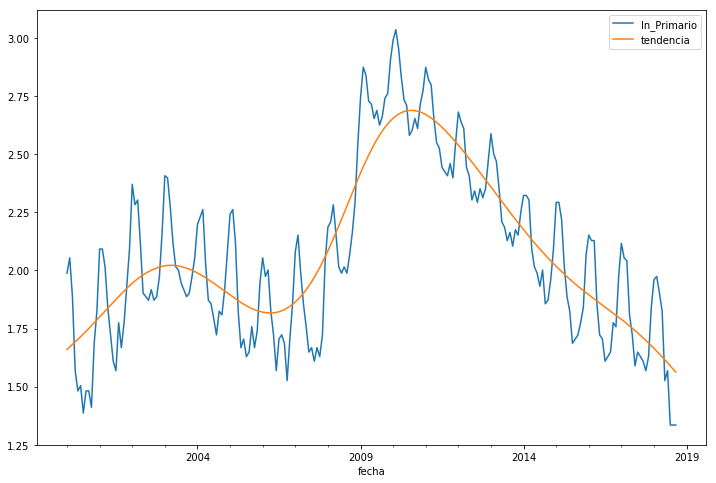

In [13]:
df[["ln_Primario","tendencia"]].plot(figsize=(12,8))                                     


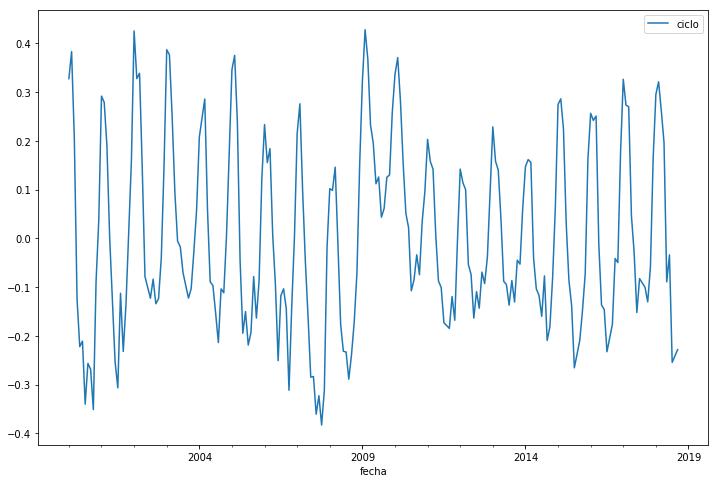

In [15]:
df[["ciclo"]].plot(figsize=(12,8)) 

Apartir de esta división podriamos pasar a estudiar la parte ciclica del paro, pero esto sera en otro notebook.